In [42]:
import logging
from Online_Update import test_then_train_env
from Online_Models import (Online_Diffusion, Online_Xgboost, Online_MA, ELM, Online_GCN,
                           Online_GAT, Online_LSTM, Online_Diffusion_Density, Single_Model, 
                           Online_Diffusion_UQ, Online_LSTM_Single)
from lib.utils import gen_data_dict, process_sensor_data
from lib.utils import seperate_up_down
import random
import torch
import numpy as np # only run this when using delftblue
from dgl.data.utils import load_graphs

preds = {}
error_dict = {}
model_dict = {}
v_dict = {}
alpha_dict = {}
e_dict = {}

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
random.seed(1)
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files
parent_dir = 'sc_sensor'
# Loop through each subdirectory in the parent directory
df_dict = process_sensor_data(parent_dir, df_dict)
data_dict = gen_data_dict(df_dict)
# online testing
# dataset_name = "crossroad"
dataset_name = "train_station"
# test_sc = ['sc_sensor/crossroad1', 'sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5',
#            'sc_sensor/crossroad1', 'sc_sensor/crossroad10', 'sc_sensor/crossroad11', 'sc_sensor/crossroad8', 'sc_sensor/crossroad2_2']
# test_sc = ['sc_sensor/crossroad1', 'sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5',
#        'sc_sensor/crossroad1', 'sc_sensor/crossroad10', 'sc_sensor/crossroad11', 'sc_sensor/crossroad8', 'sc_sensor/crossroad2_2']
# test_sc = ['sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5']
# train_sc = ['sc_sensor/train3']
# test_sc = ['sc_sensor/train1','sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4']
test_sc = ['sc_sensor/train1','sc_sensor/train3', 'sc_sensor/train5',
           'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4',
           'sc_sensor/train1_2', 'sc_sensor/train7']

#seperate upstream and downstream
data_dict = seperate_up_down(data_dict)
g_data = load_graphs('./graphs/graphs.bin')
if dataset_name == "crossroad":
    g = g_data[0][0]

elif dataset_name == "train_station":
    g = g_data[0][1]
# if dataset_name == "crossroad":
#     file_path = 'graphs/graph_data_crossroad.pkl'
#     with open(file_path, 'rb') as file:
#         g = pickle.load(file)
# 
# elif dataset_name == "train_station":
#     file_path = 'graphs/graph_data_trainstation.pkl'
#     with open(file_path, 'rb') as file:
#         g = pickle.load(file)

chunk_size = 60
lags = 5
'''Has to >= 2'''
pred_horizon = 5 # 3, 5
# test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g)
test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g, logger=logger)
test_env.device = device

In [3]:
mdl = "ma"
# mdl = "diffusion"
# mdl = "diffusion_uq"
# mdl = "diffusion_density"
# mdl = "xgboost"
# mdl = "elm"
# mdl = "gcn"
# mdl = "gat"
# mdl = "lstm"
# mdl = "lstm_sig"
if mdl == "diffusion":
    model = Single_Model(model_type=Online_Diffusion, dataset=dataset_name, g=g, pred_horizon=pred_horizon, lags=lags, device=device, 
                         chunk_size=chunk_size, train_steps=130, buffer=True)
elif mdl == "xgboost":
    model = Single_Model(model_type=Online_Xgboost, g=g, dataset=dataset_name, pred_horizon=pred_horizon,
                         lags=lags, device=device, chunk_size=chunk_size, train_steps=None, buffer=False)
elif mdl == "ma":
    model = Single_Model(model_type=Online_MA, g=g, pred_horizon=pred_horizon, lags=lags, device=device,
                         chunk_size=chunk_size, train_steps=None)
elif mdl == "elm":
    model = Single_Model(model_type=ELM, g=g, pred_horizon=pred_horizon, lags=lags, device=None, hidden_units=64, train_steps=None, buffer=False)
elif mdl == "gcn":
    model = Single_Model(model_type=Online_GCN, chunk_size=chunk_size, g=g, pred_horizon=pred_horizon, 
                         lags=lags, device=device, hidden_units=128, train_steps=100)
elif mdl == "gat":
    model = Single_Model(model_type=Online_GAT, g=g, hidden_units=32, pred_horizon=pred_horizon, 
                         lags=lags, device=device, num_heads=3, train_steps=200, chunk_size=chunk_size)
elif mdl == "lstm":
    model = Single_Model(model_type=Online_LSTM, g=g, pred_horizon=pred_horizon, 
                         lags=lags, device=device, hidden_units=64, chunk_size=chunk_size, num_layers=2, train_steps=200, buffer=True)
elif mdl == "lstm_sig":
    model = Single_Model(model_type=Online_LSTM_Single, g=g, pred_horizon=pred_horizon, lags=lags, device=device, hidden_units=32,
                     chunk_size=chunk_size, num_layers=2, train_steps=200, buffer=True)
elif mdl == "diffusion_uq":
    model = Single_Model(model_type=Online_Diffusion_UQ, g=g, pred_horizon=pred_horizon, lags=lags, device=device,
                         train_steps=130, chunk_size=chunk_size, buffer=True)
elif mdl == "diffusion_density":
    model = Single_Model(model_type=Online_Diffusion_Density, g=g, pred_horizon=pred_horizon, lags=lags, device=device, 
                         chunk_size=chunk_size, train_steps=150, buffer=True)
else:
    raise ValueError("model type not found")
# model, curve_data, preds[mdl] = test_env.test_then_train(model)
model, curve_data, preds[mdl], v, alpha, e = test_env.test_then_train(model)
error_dict[mdl] = curve_data
model_dict[mdl] = model
if mdl in ["diffusion", "diffusion_uq", "diffusion_density"]:
    v_dict[mdl] = torch.cat(v, dim=1).detach().numpy()
    alpha_dict[mdl] = torch.cat(alpha, dim=1).detach().numpy()
    e_dict[mdl] = torch.cat(e, dim=1).detach().numpy()

2024-03-04 14:34:36,470 - INFO - error per sc_sensor/train1 chunk: 0: 3.3749680519104004
2024-03-04 14:34:36,471 - INFO - error per sc_sensor/train1 chunk: 30: 5.542321681976318
2024-03-04 14:34:36,472 - INFO - error per sc_sensor/train1 chunk: 60: 4.450060844421387
2024-03-04 14:34:36,473 - INFO - error per sc_sensor/train1 chunk: 90: 5.105545997619629
2024-03-04 14:34:36,473 - INFO - error per sc_sensor/train1 chunk: 120: 4.900228023529053
2024-03-04 14:34:36,474 - INFO - error per sc_sensor/train1 chunk: 150: 4.568120956420898
2024-03-04 14:34:36,475 - INFO - error per sc_sensor/train1 chunk: 180: 4.3049821853637695
2024-03-04 14:34:36,476 - INFO - error per sc_sensor/train1 chunk: 210: 3.352198600769043
2024-03-04 14:34:36,477 - INFO - error per sc_sensor/train1 chunk: 240: 5.61763334274292
2024-03-04 14:34:36,478 - INFO - error per sc_sensor/train1 chunk: 270: 5.1483869552612305
2024-03-04 14:34:36,478 - INFO - error per sc_sensor/train1 chunk: 300: 4.658141613006592
2024-03-04 14

In [44]:
model_list = ["Online_Diffusion", "Online_Diffusion_UQ", "Online_Xgboost", "Online_MA", "ELM", "Online_GCN", 
              "Online_GAT", "Online_LSTM", "Online_Diffusion_Density", "Online_LSTM_Single"]
train_steps = 130
for m in model_list:
    try:
        error_dict[m] = np.load(f"checkpoint/{m}_{dataset_name}_curve_error_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        preds[m] = np.load(f"checkpoint/{m}_{dataset_name}_prediction_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    except:
        print(f"model_{m}, file not found")
        continue


model_Online_Diffusion_UQ, file not found
model_Online_Xgboost, file not found
model_Online_MA, file not found
model_ELM, file not found
model_Online_GCN, file not found
model_Online_GAT, file not found
model_Online_Diffusion_Density, file not found
model_Online_LSTM_Single, file not found


In [46]:
from lib.utils import sliding_win  # to get the online label
label_list = []
sigma_list = []
# model = model_dict["diffusion_uq"]
for sc in test_sc:
    data = data_dict[sc]

    observation, label = sliding_win(data, lags=test_env.lags, horizons=test_env.pred_horizon)
    observation, label = torch.FloatTensor(observation).permute(2, 0, 1), torch.FloatTensor(label).permute(2, 0, 1)
    for i in range(0, observation.shape[1] - test_env.chunk_size, test_env.chunk_size):
        # pred = model.predict(observation[:, i:i+chunk_size, :])
        try:
            sigma_list.append(model.model.g.ndata['sigma'])
        except:
            pass
        label_list.append(label[:, i:i+test_env.chunk_size, :])

labels = torch.stack(label_list, dim=0)
sigma = torch.stack(sigma_list, dim=0).detach()

RuntimeError: stack expects a non-empty TensorList

In [52]:
# visualize preds and labels
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
node = 7
step = -1

label = np.transpose(labels, [0, 2, 1, 3]).reshape(-1, labels.shape[1], labels.shape[3])
def visualize(mdl, preds, label, step, node):
    time = 1400
    start = 300
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3]) # [batch, node, horizon]
    plt.figure(figsize=(20, 5))
    # x = np.arange(time - start)
    label = label[start:time, node, step]
    pred = pred[start:time, node, step]
    x = np.arange(len(label))
    sns.lineplot(x=x, y=label, label='label')
    sns.lineplot(x=x, y=pred, label='pred')
    # if mdl == "diffusion_uq":
    #     # sigma = torch.stack(sigma_list, dim=0)
    #     sig = sigma.permute(2, 0, 1).reshape([-1, sigma.shape[1]]).numpy()
    #     sig = np.sqrt(pred[:, :, step] + pred[:, :, step] ** 2 * sig)
    #     plt.fill_between(x, pred[start:time, node, 0] - 2 * sig[start:time, node], pred[start:time, node, 0] + 2 * sig[start:time, node], alpha=0.5)

    #limit
    plt.ylim(0, 35)

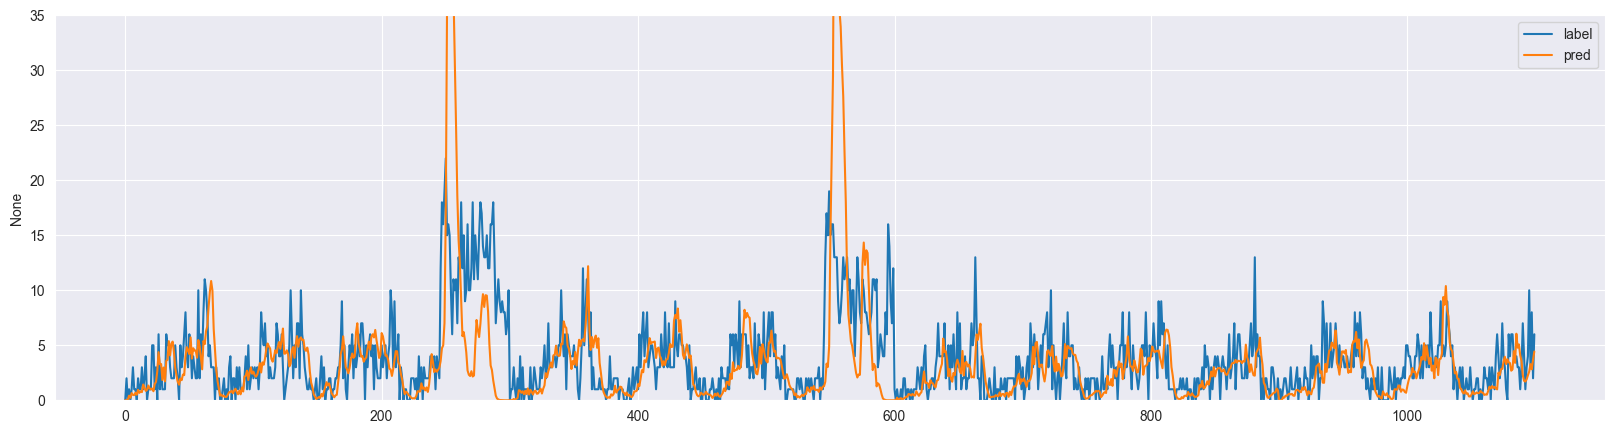

In [56]:
visualize("Online_Diffusion", preds, label, -1, 2)

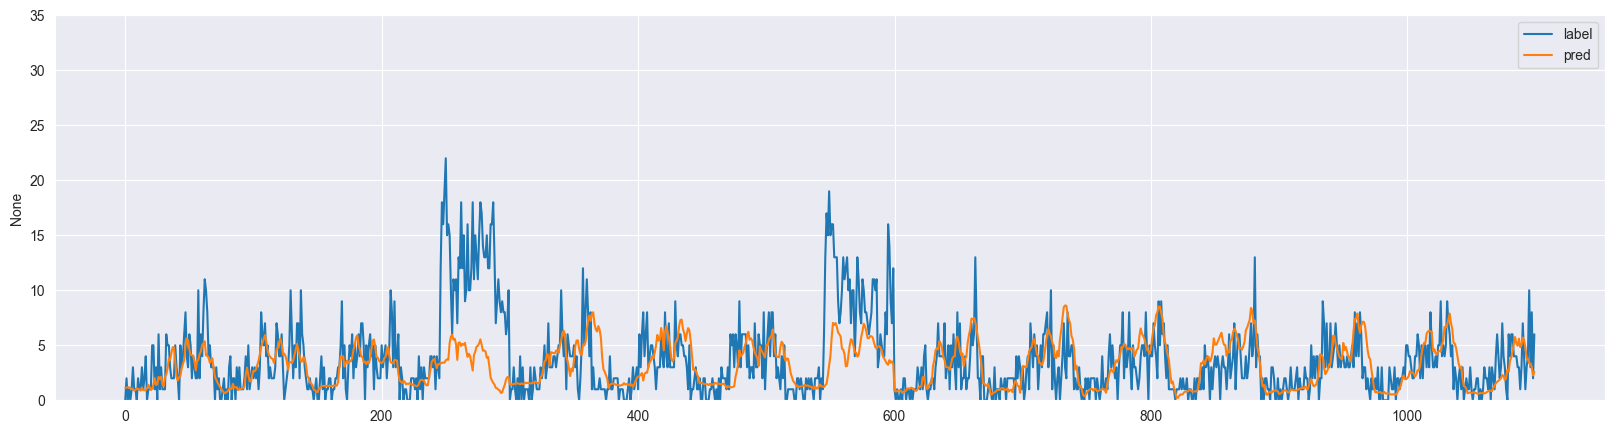

In [57]:
visualize("Online_LSTM", preds, label, -1, 2)

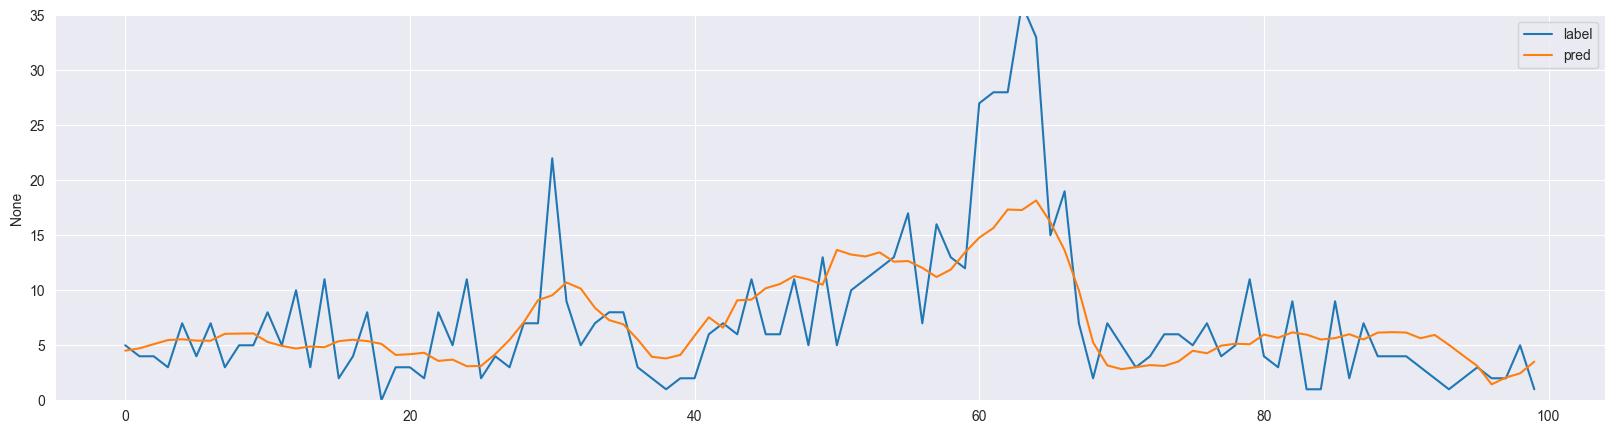

In [40]:
visualize("Online_LSTM", preds, label, -1, 22)

In [5]:
visualize("lstm_sig", preds, label, -1, 2)

NameError: name 'visualize' is not defined

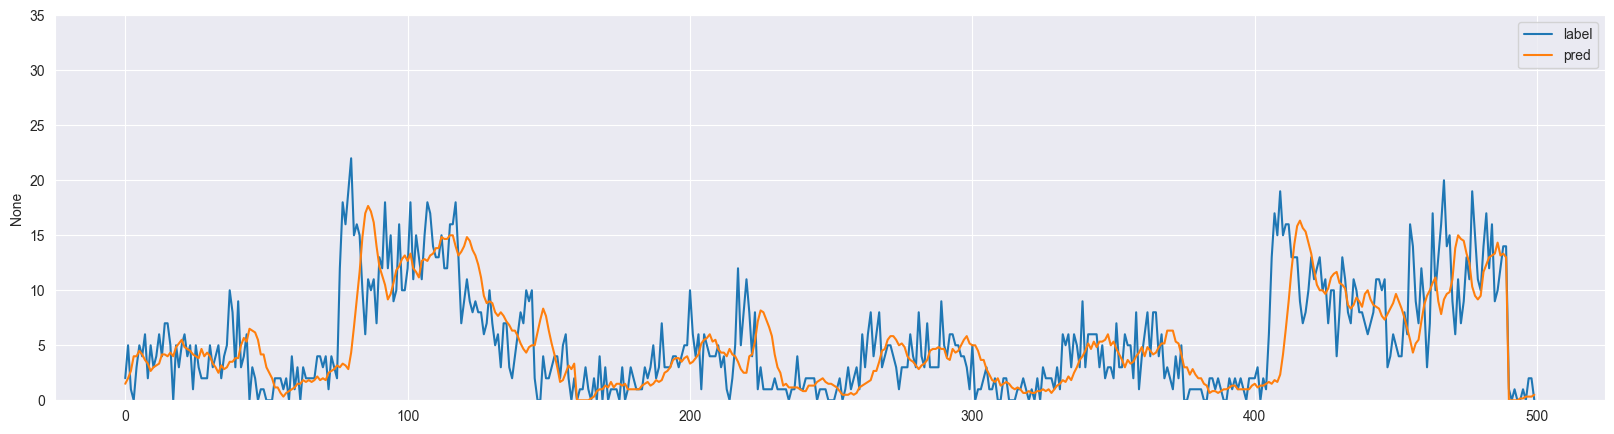

In [11]:
visualize("ma", preds, label, -1, 2)

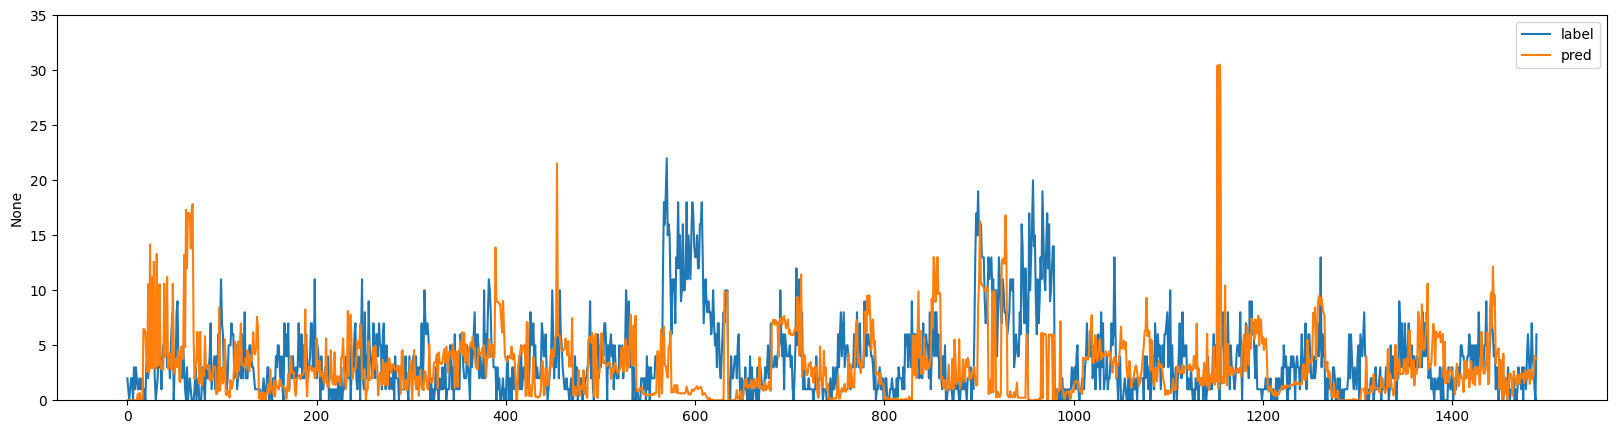

In [13]:
visualize("xgboost", preds, label, -1, 2)

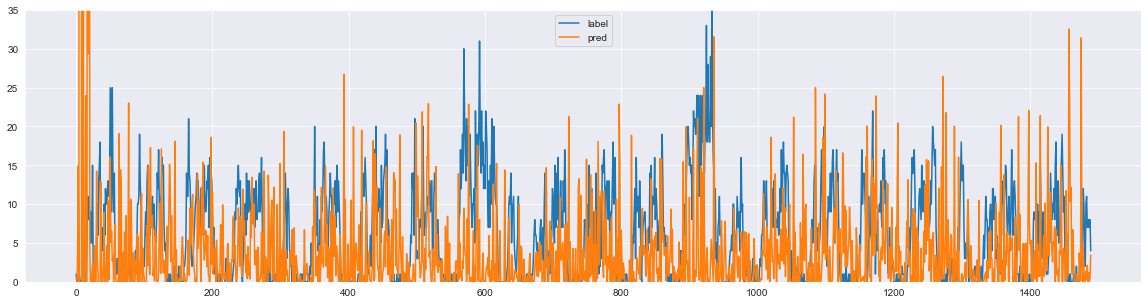

In [128]:
visualize("elm", preds, label, -1, 1)

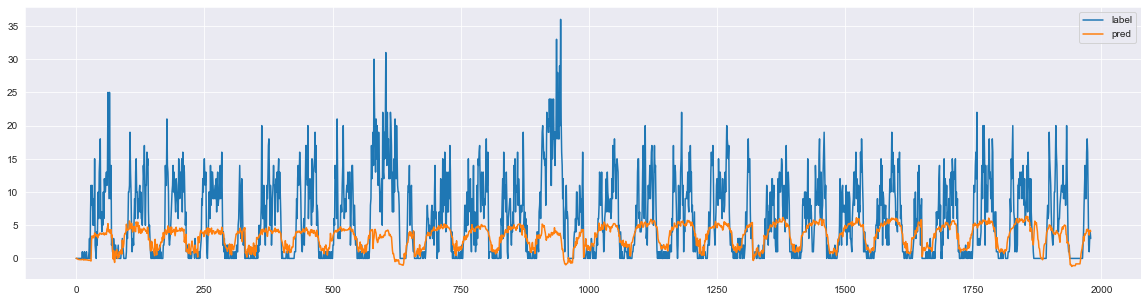

In [9]:
visualize("gat", preds, label, 1, 1)

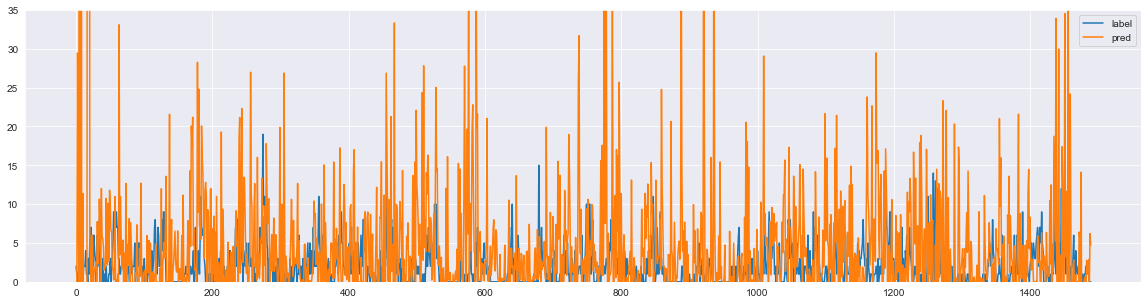

In [125]:
visualize("elm", preds, label, -1, 15)

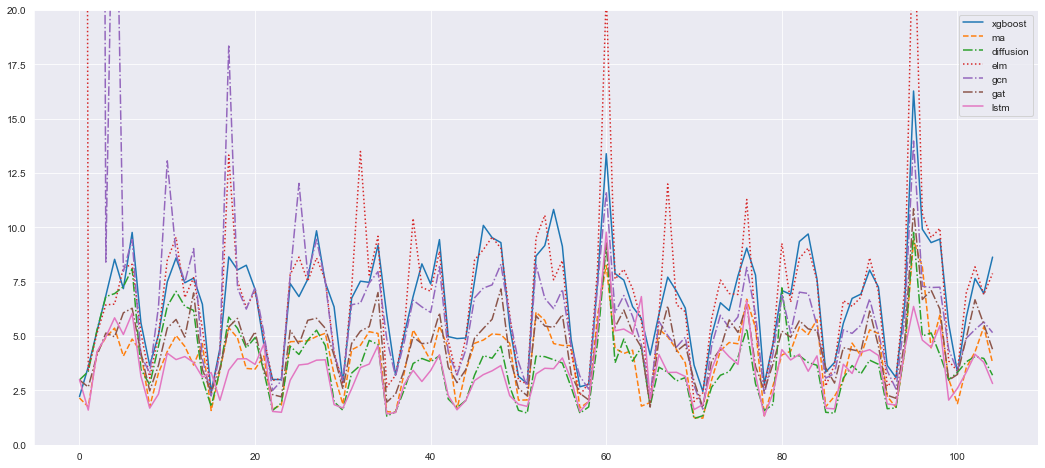

In [31]:
# visualize error
x = np.arange(len(error_dict[mdl]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=x, y=error_dict[mdl_name], label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)


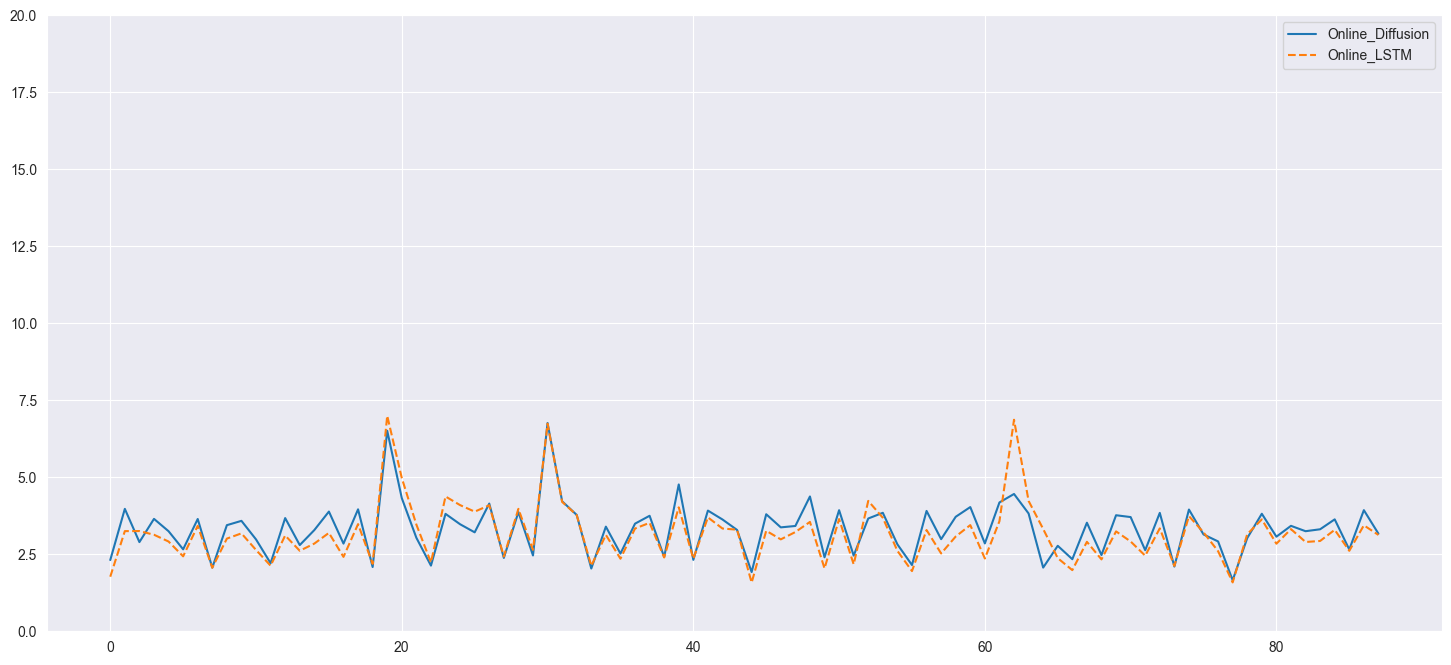

In [30]:
x = np.arange(len(error_dict["Online_LSTM"]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=x, y=np.mean(error_dict[mdl_name][:, :], axis=1), label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)

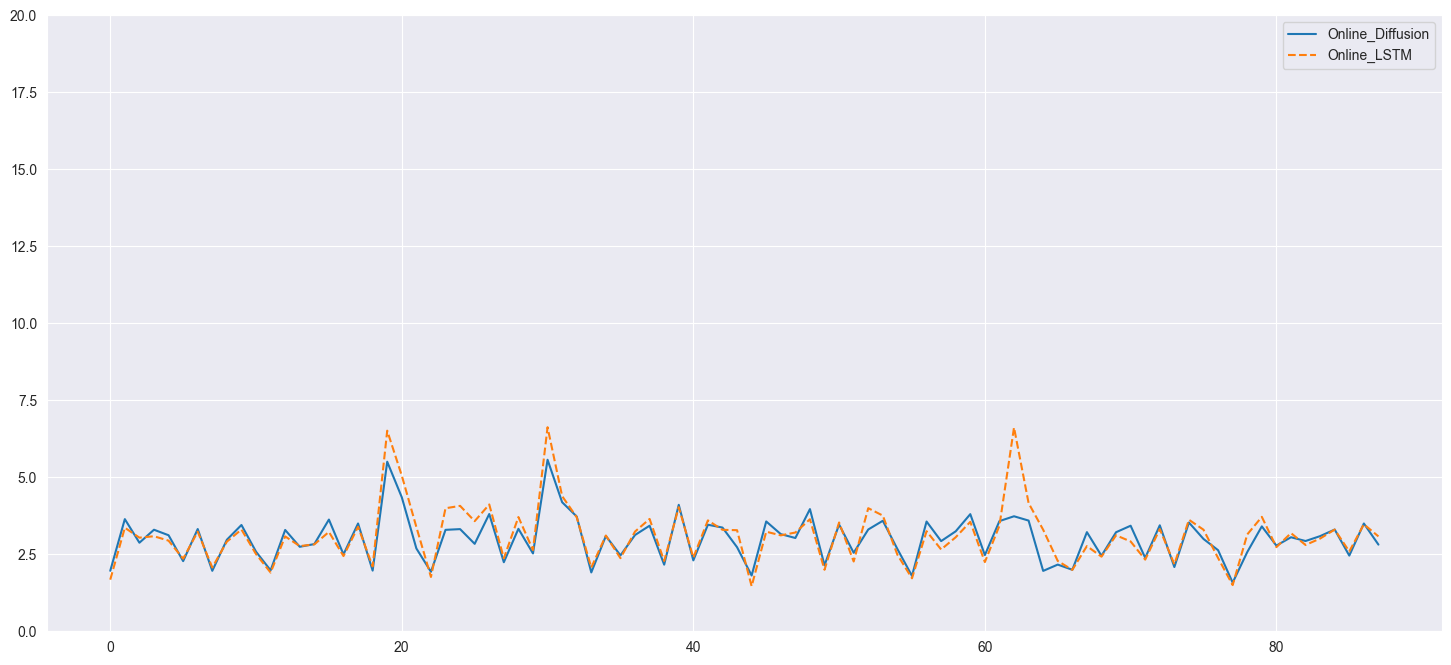

In [29]:
x = np.arange(len(error_dict["Online_LSTM"]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=x, y=error_dict[mdl_name][:, -1], label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)

In [118]:
stepid = 3
np.sum(error_dict['diffusion'][:,stepid]), np.sum(error_dict['diffusion_uq'][:,stepid]), np.sum(error_dict['lstm'][:,stepid])

(1042.8267, 1017.64636, 1014.2279)

In [22]:
for model_name in error_dict.keys():
    print(f"{model_name} error: {np.sum(error_dict[model_name])}")

lstm_sig error: 1893.284423828125
diffusion error: 1192.978515625
diffusion_uq error: 1213.2471923828125
ma error: 1517.0760498046875
lstm error: 1169.51171875


In [42]:
stepid = 3
for model_name in error_dict.keys():
    print(f"{model_name} error: {np.sum(error_dict[model_name][:,stepid])}")

Online_Diffusion error: 331.0052795410156
Online_LSTM error: 287.711181640625


In [67]:
from lib.metric import weighted_average_loss, quantile_loss_np, masked_mae_np, masked_rmse_np
for model_name in error_dict.keys():
    pred = np.transpose(preds[model_name], [0, 2, 3, 1]).reshape(-1, preds[model_name].shape[3], preds[model_name].shape[1], 1)
    target = np.expand_dims(np.transpose(label, [0, 2, 1]), -1)
    mae = masked_mae_np(pred, target)
    rmse = masked_rmse_np(pred, target)
    # l, wt, gamma = weighted_average_loss(pred, target, rho=0.5, timespan=1, mode=0)
    l, wt, gamma = weighted_average_loss(pred[..., :2, :], target[..., :2, :], rho=0.9, timespan=1, mode=0)
    qt_l = quantile_loss_np(pred[..., :2, :], target[..., :2, :], 0.9)
    print(f"{model_name} error: {l}, quantile loss: {qt_l}, mae: {mae}, rmse: {rmse}")

Online_Diffusion error: 5.047702431678772, quantile loss: (9.032593, 36.2723991394043), mae: 2.4661364555358887, rmse: 4.642363548278809
Online_LSTM error: 2.4459957480430603, quantile loss: (3.229831, 42.03331871032715), mae: 2.1488735675811768, rmse: 3.4007599353790283


In [63]:
pred.shape, target.shape

((2640, 4, 24, 1), (2640, 4, 24, 1))

In [122]:
#pred [N, horizon, node, 1
l, wt, gamma = weighted_average_loss(pred, target, rho=0.9, timespan=3, mode=0)
l, wt[-1, 2, 0]

(6.084234737439289, 2.7817131519317626)

In [123]:
quantile_loss_np(pred, target, 0.9)

(10.894815, 24.72950038909912)

In [29]:
torch.save(model_dict["diffusion_density"].model.model.state_dict(), "./checkpoint/diffusion/online_diffusion_density.pth")

In [58]:
import numpy as np
dataset = "train_station"
# dataset = "crossroad"
for m in ["Online_Diffusion", "Online_Diffusion_UQ"]:
    error_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_curve_error_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    v_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_v_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    alpha_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_alpha_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
# v_dict["diffusion_uq"] = np.load(f"./checkpoint/{dataset}_v_chunk{chunk_size}_lags{lags}_hor{pred_horizon}_Online_Diffusion_UQ.npy")
# alpha_dict["diffusion_uq"] = np.load(f"./checkpoint/{dataset}_alpha_chunk{chunk_size}_lags{lags}_hor{pred_horizon}_Online_Diffusion_UQ.npy")
# error_dict["diffusion_uq"] = np.load(f"./checkpoint/{dataset}_curve_error_chunk{chunk_size}_lags{lags}_hor{pred_horizon}_Online_Diffusion_UQ.npy")

FileNotFoundError: [Errno 2] No such file or directory: './checkpoint/Online_Diffusion_UQ_train_station_curve_error_chunk60_lags5_hor5.npy'

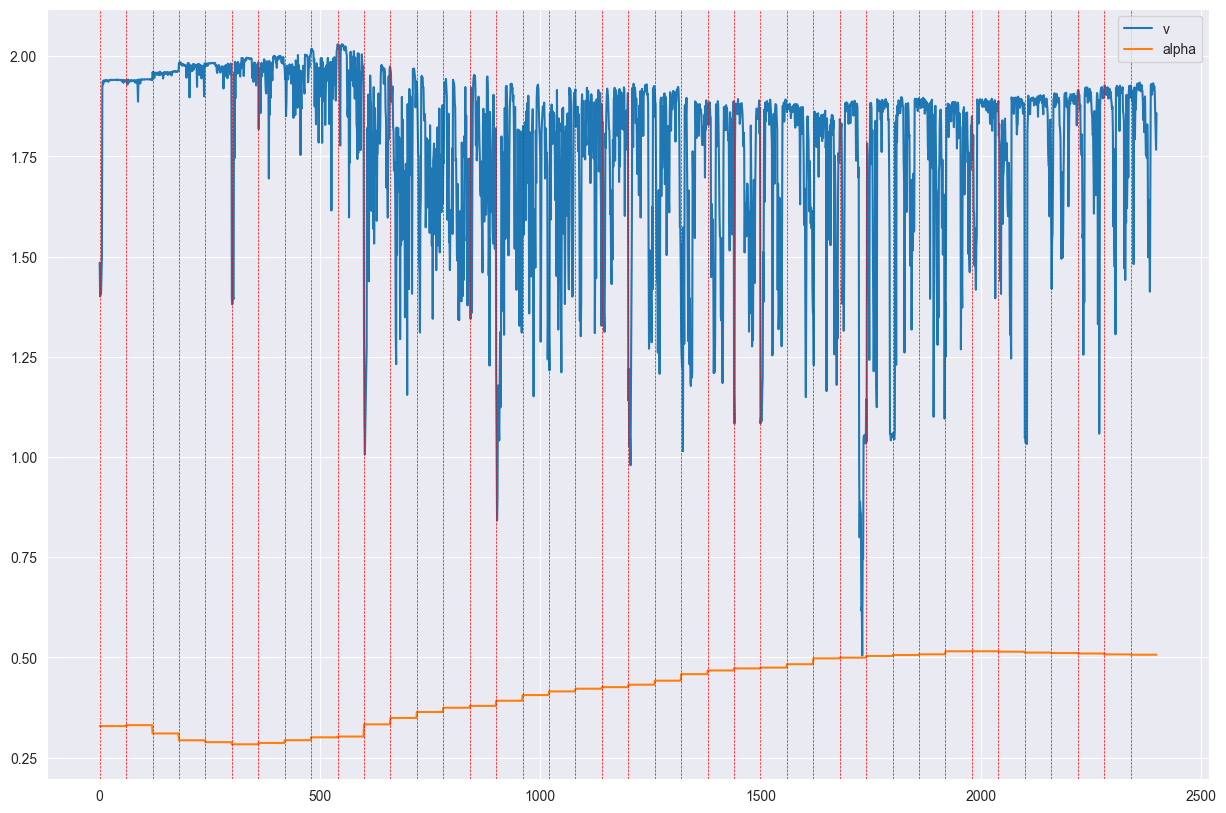

In [59]:
import matplotlib.pyplot as plt
# get the edge id by src and dst
src = 7
dst = 2
# try:
#     v = torch.cat(v, dim=1).detach().numpy()
#     alpha = torch.cat(alpha, dim=1).detach().numpy()
# except:
#     pass
v = v_dict["Online_Diffusion"]
alpha = alpha_dict["Online_Diffusion"]
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], chunk_size):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

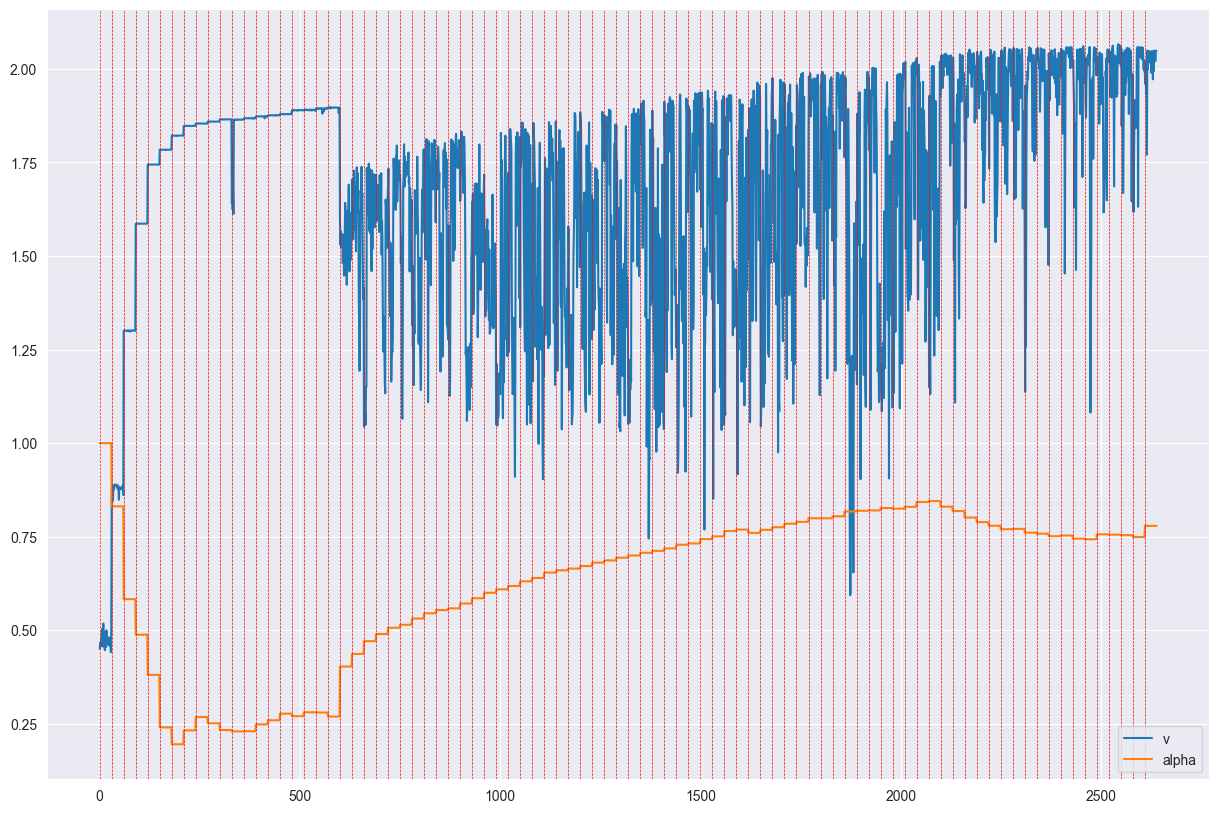

In [11]:
src = 7
dst = 2
v = v_dict["Online_Diffusion_UQ"]
alpha = alpha_dict["Online_Diffusion_UQ"]
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], chunk_size):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

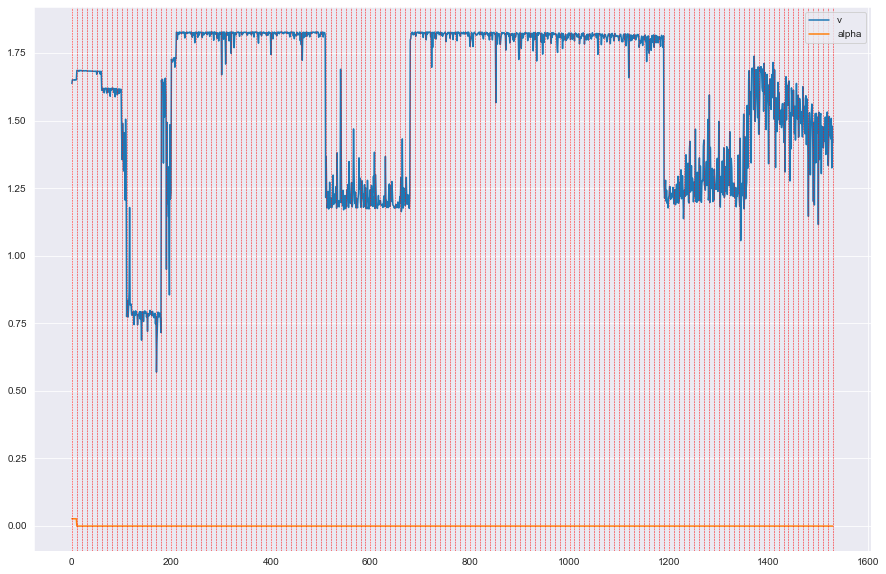

In [95]:
import matplotlib.pyplot as plt
# get the edge id by src and dst
src = 0
dst = 4
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1]+10, 10):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

In [6]:
alpha[edge_id, :]

array([ 0.1       ,  0.1       ,  0.1       , ..., -0.04154234,
       -0.04154234, -0.04154234], dtype=float32)

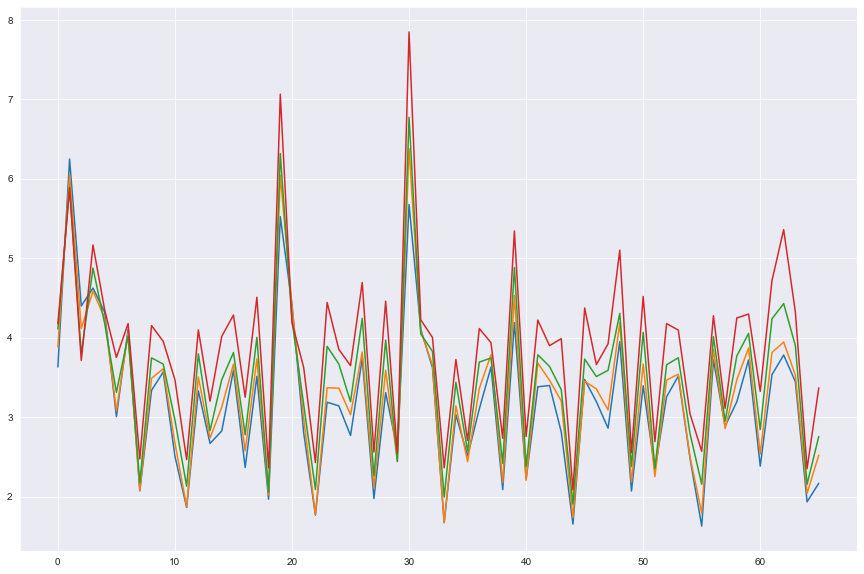

In [62]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(error.shape[0]), error)

In [45]:
alpha = alpha_dict["diffusion"]

In [51]:
num_nodes = g.number_of_nodes()
src, dst = g.edges()
with torch.no_grad():
    num_edges = len(src)
    sample_size = alpha.shape[1]
    atten_mat = np.zeros([num_nodes, num_nodes, sample_size])
    for i in range(num_edges):
        atten_mat[src[i], dst[i], :] = alpha[i, :]

<AxesSubplot:>

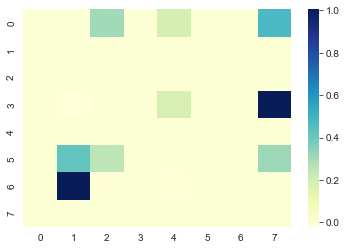

In [58]:
# visualize attention matrix
import seaborn as sns
sns.heatmap(atten_mat[..., -1], cmap="YlGnBu")